In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, normaltest, zscore, ks_2samp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

df_final = pd.read_csv("final_df.csv")

print("Shape:", df_final.shape)
display(df_final.head())


Shape: (49181, 42)


,battery_id,cycle_index,protocol_id,discharge_capacity_ah_max,discharge_capacity_ah_mean,discharge_capacity_ah_min,charge_capacity_ah_max,charge_capacity_ah_mean,charge_capacity_ah_min,voltage_v_max,...,rolling_mean_soh_percent,rolling_std_discharge_capacity_ah_max,rolling_std_charge_capacity_ah_max,rolling_std_voltage_v_max,rolling_std_current_a_mean,rolling_std_discharge_energy_wh_max,rolling_std_charge_energy_wh_max,rolling_std_aux_temperature_1_c_mean,rolling_std_current_a_abs_mean,rolling_std_soh_percent
0,1,1,1,2.421769,0.849490,3.200319e-05,2.394174,2.115371,0.003330,4.200036,...,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,1,2.400751,0.442225,2.473989e-10,2.416324,1.819254,0.003330,4.200032,...,99.566061,0.014862,0.015662,0.000003,0.003854,0.228743,0.055605,0.524013,0.435901,0.613682
2,1,3,1,2.399412,0.442961,2.987066e-05,2.396731,1.805943,0.003330,4.200024,...,99.402985,0.012539,0.012118,0.000006,0.002735,0.187687,0.043485,0.444561,0.355911,0.517769
3,1,4,1,2.397874,0.443705,3.193769e-05,2.394747,1.803746,0.003329,4.200034,...,99.305570,0.011273,0.010610,0.000005,0.002262,0.163473,0.038482,0.387616,0.308554,0.465491
4,1,5,1,2.397038,0.443911,3.313753e-05,2.393583,1.802770,0.003329,4.200028,...,99.240217,0.010384,0.009694,0.000005,0.001984,0.146851,0.035502,0.347763,0.276177,0.428797


In [8]:
num_cols = df_final.select_dtypes(include=["int64", "float64"]).columns.tolist()
TARGET_COL = "rul" if "rul" in df_final.columns else None

In [50]:
print("=== BASIC INFO ===")
print(df_final.info())

print("\nMissing values (%):")
missing_pct = (df_final.isnull().mean() * 100).round(2).sort_values(ascending=False)
print(missing_pct.head(30))

print("\nDescriptive statistics (numeric):")
display(df_final[num_cols].describe().T)

=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49181 entries, 0 to 49180
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   battery_id                              49181 non-null  int64  
 1   cycle_index                             49181 non-null  int64  
 2   protocol_id                             49181 non-null  int64  
 3   discharge_capacity_ah_max               49181 non-null  float64
 4   discharge_capacity_ah_mean              49181 non-null  float64
 5   discharge_capacity_ah_min               49181 non-null  float64
 6   charge_capacity_ah_max                  49181 non-null  float64
 7   charge_capacity_ah_mean                 49181 non-null  float64
 8   charge_capacity_ah_min                  49181 non-null  float64
 9   voltage_v_max                           49181 non-null  float64
 10  voltage_v_mean                         

,count,mean,std,min,25%,50%,75%,max
battery_id,49181.0,46.145076,28.614104,1.000000,1.800000e+01,49.000000,75.000000,86.000000
cycle_index,49181.0,444.591224,335.559031,1.000000,1.580000e+02,370.000000,694.000000,1436.000000
protocol_id,49181.0,8.163437,5.513959,1.000000,3.000000e+00,8.000000,14.000000,16.000000
discharge_capacity_ah_max,49181.0,2.174415,0.203689,0.007272,2.047859e+00,2.215638,2.323798,2.628877
discharge_capacity_ah_mean,49181.0,0.506661,0.183418,0.003884,3.758223e-01,0.470649,0.649720,0.858387
discharge_capacity_ah_min,49181.0,0.000029,0.000029,0.000000,4.174549e-09,0.000028,0.000035,0.000119
charge_capacity_ah_max,49181.0,2.170631,0.204534,0.000000,2.043762e+00,2.211252,2.319157,2.649760
charge_capacity_ah_mean,49181.0,1.764774,0.198850,0.000000,1.622271e+00,1.771508,1.909988,2.339464
charge_capacity_ah_min,49181.0,0.004033,0.001872,0.000000,3.327275e-03,0.003329,0.003331,0.013334
voltage_v_max,49181.0,4.206238,0.026712,3.228723,4.200032e+00,4.200038,4.200046,4.300264


In [49]:
print("\n=== EXTENDED STATS (mean/std/skew/kurtosis) ===")

stats_df = pd.DataFrame({
    "mean": df_final[num_cols].mean(),
    "std": df_final[num_cols].std(),
    "min": df_final[num_cols].min(),
    "max": df_final[num_cols].max(),
    "skew": df_final[num_cols].skew(),
    "kurtosis": df_final[num_cols].kurtosis(),})

display(stats_df.sort_values("skew", ascending=False).head(15))


=== EXTENDED STATS (mean/std/skew/kurtosis) ===


,mean,std,min,max,skew,kurtosis
rolling_std_voltage_v_max,0.003845,0.016035,0.000000,0.489681,11.891161,265.726673
rolling_std_discharge_capacity_ah_max,0.038846,0.045363,0.000000,1.265785,9.125381,193.453801
rolling_std_soh_percent,1.595841,1.862490,0.000000,51.937290,9.098285,192.608636
rolling_std_charge_capacity_ah_max,0.040596,0.048091,0.000000,1.269204,7.956728,156.389982
rolling_std_charge_energy_wh_max,0.167014,0.192904,0.000000,4.979498,7.455349,141.237788
rolling_std_discharge_energy_wh_max,0.264722,0.212813,0.000000,4.586455,4.254835,60.133587
charge_capacity_ah_min,0.004033,0.001872,0.000000,0.013334,2.961684,8.937175
rolling_mean_voltage_v_max,4.206224,0.022257,3.845050,4.280088,2.192808,14.594200
aux_temperature_1_c_max,31.925698,7.710359,24.573080,58.917418,1.697455,1.853699
rolling_std_current_a_mean,0.011445,0.011935,0.000000,0.163545,1.600905,4.481876


In [48]:
print("=== NORMALITY TEST (p-values) ===")

normality_p = {}
for col in num_cols:
    data = df_final[col].dropna()
    if len(data) > 5000: 
        data = data.sample(5000, random_state=42)
    stat, p = normaltest(data)
    normality_p[col] = p

normality_series = pd.Series(normality_p).sort_values()
print("10 most non-normal (lowest p-values):")
print(normality_series.head(10))

=== NORMALITY TEST (p-values) ===
10 most non-normal (lowest p-values):
battery_id                     0.0
protocol_id                    0.0
voltage_v_max                  0.0
charge_capacity_ah_min         0.0
voltage_v_min                  0.0
rolling_mean_voltage_v_max     0.0
aux_temperature_1_c_max        0.0
aux_temperature_1_c_min        0.0
rolling_mean_current_a_mean    0.0
rolling_std_soh_percent        0.0
dtype: float64


=== NUMERICAL DISTRIBUTIONS ===


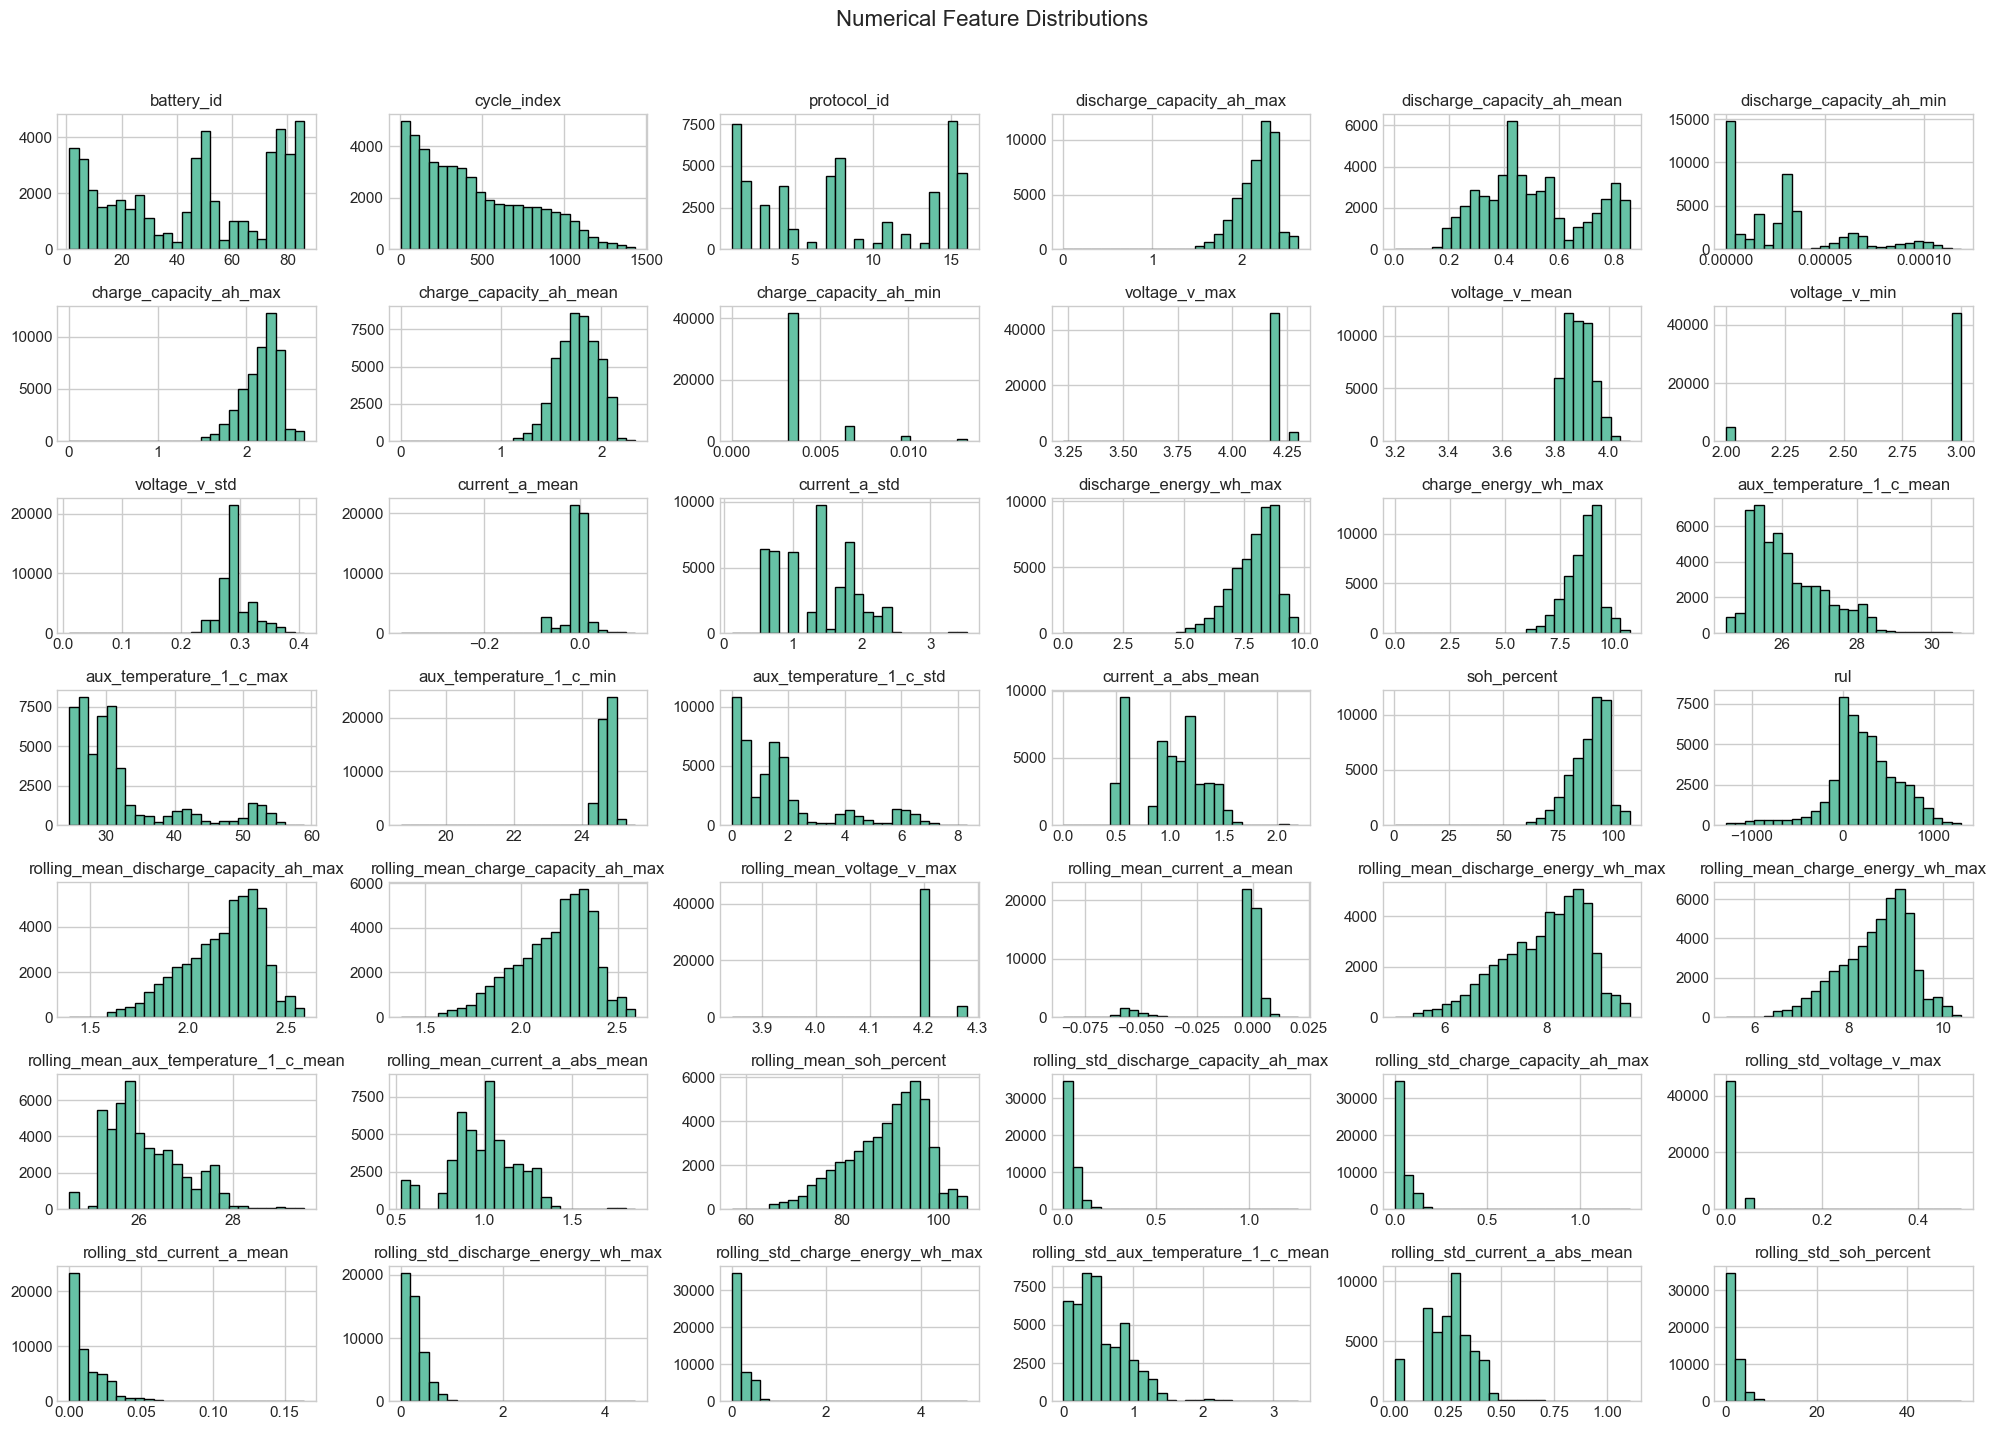

In [47]:
print("=== NUMERICAL DISTRIBUTIONS ===")

_ = df_final[num_cols].hist(bins=25, figsize=(20, 14), edgecolor="black")
plt.suptitle("Numerical Feature Distributions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

=== CORRELATIONS ===


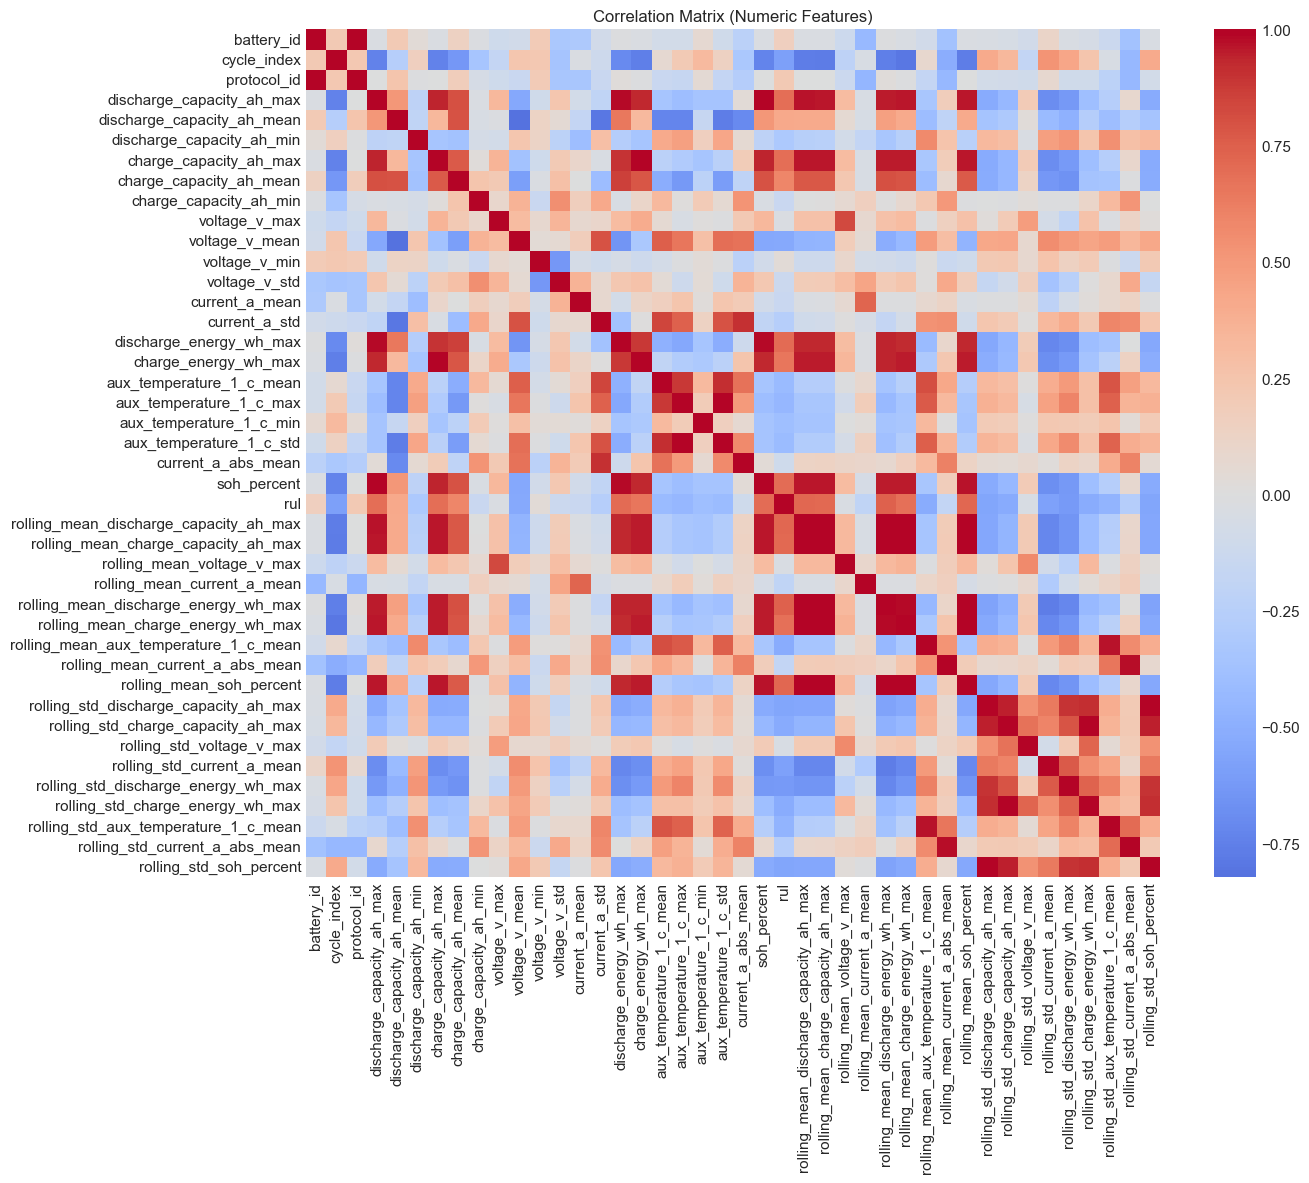

Correlations with target (RUL):
rul                                       1.000000
rolling_mean_discharge_energy_wh_max      0.747388
rolling_mean_soh_percent                  0.720013
rolling_mean_discharge_capacity_ah_max    0.716595
rolling_mean_charge_capacity_ah_max       0.714010
discharge_energy_wh_max                   0.704203
soh_percent                               0.696056
discharge_capacity_ah_max                 0.692888
charge_capacity_ah_max                    0.687541
rolling_mean_charge_energy_wh_max         0.685397
charge_energy_wh_max                      0.656144
charge_capacity_ah_mean                   0.594112
discharge_capacity_ah_mean                0.419495
protocol_id                               0.213715
battery_id                                0.153420
voltage_v_min                             0.032629
voltage_v_max                            -0.027858
rolling_mean_voltage_v_max               -0.033853
rolling_std_voltage_v_max                -0.040737

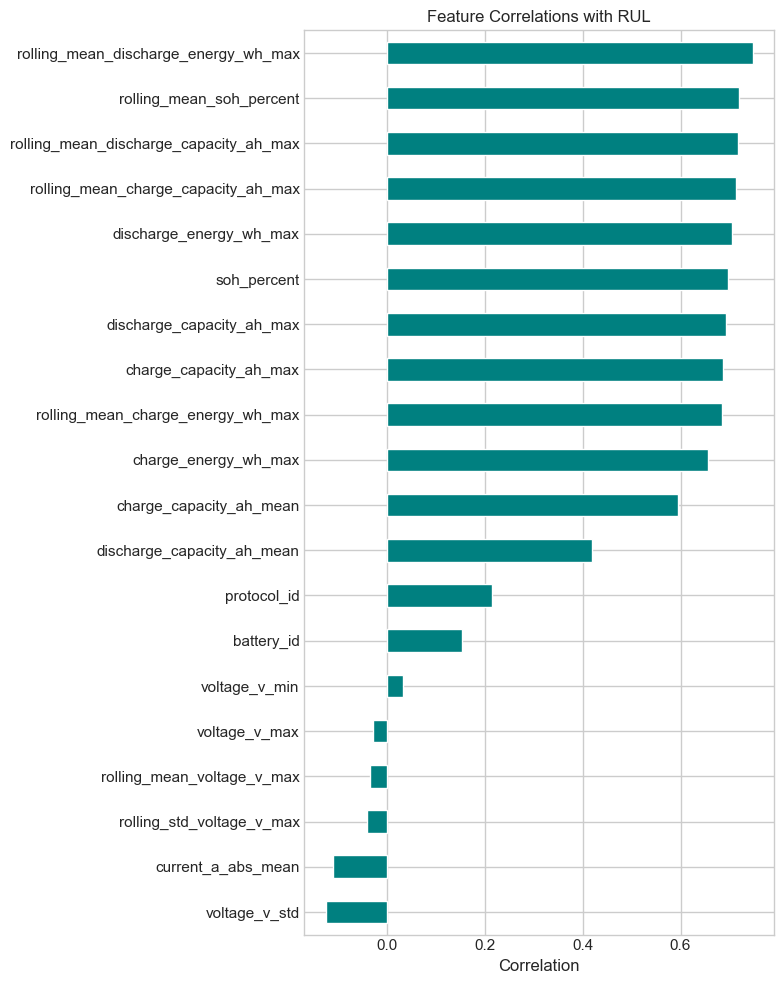

In [46]:
print("=== CORRELATIONS ===")

corr_mat = df_final[num_cols].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_mat, cmap="coolwarm", center=0, square=False)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()

if TARGET_COL is not None:
    corr_target = corr_mat[TARGET_COL].sort_values(ascending=False)
    print("Correlations with target (RUL):")
    print(corr_target)
    plt.figure(figsize=(8, 10))
    corr_target.drop(TARGET_COL).head(20).sort_values().plot(kind="barh", color="teal")
    plt.title("Feature Correlations with RUL")
    plt.xlabel("Correlation")
    plt.tight_layout()
    plt.show()

In [ ]:
print("=== MULTICOLLINEARITY (VIF) ===")

# Use a subset of numeric columns (exclude target)
vif_cols = [c for c in num_cols if c != TARGET_COL]
X_vif = df_final[vif_cols].dropna()

# For speed, sample rows if very large
if len(X_vif) > 10000:
    X_vif = X_vif.sample(10000, random_state=42)

vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_df = vif_df.sort_values("VIF", ascending=False)
print("Top 15 features by VIF:")
print(vif_df.head(15))


=== MULTICOLLINEARITY (VIF) ===
Top 15 features by VIF:
                                   feature           VIF
23  rolling_mean_discharge_capacity_ah_max  3.594170e+08
3                discharge_capacity_ah_max  3.590253e+08
31                rolling_mean_soh_percent  3.563123e+08
22                             soh_percent  3.559771e+08
9                            voltage_v_max  3.654240e+06
10                          voltage_v_mean  2.541151e+06
24     rolling_mean_charge_capacity_ah_max  1.359356e+06
16                    charge_energy_wh_max  9.559068e+05
6                   charge_capacity_ah_max  8.997190e+05
25              rolling_mean_voltage_v_max  7.011038e+05
28       rolling_mean_charge_energy_wh_max  6.519164e+05
32   rolling_std_discharge_capacity_ah_max  4.389572e+05
40                 rolling_std_soh_percent  4.389033e+05
15                 discharge_energy_wh_max  4.084025e+05
27    rolling_mean_discharge_energy_wh_max  3.335483e+05


=== OUTLIER DETECTION (Z-score > 3) ===
rolling_mean_voltage_v_max               0.079360
voltage_v_max                            0.063520
rolling_mean_current_a_mean              0.060186
charge_capacity_ah_min                   0.048149
current_a_mean                           0.038734
rolling_std_current_a_mean               0.017751
rul                                      0.013847
rolling_std_aux_temperature_1_c_mean     0.007727
rolling_mean_aux_temperature_1_c_mean    0.006710
aux_temperature_1_c_mean                 0.006425
voltage_v_std                            0.006222
rolling_std_current_a_abs_mean           0.006100
discharge_energy_wh_max                  0.005653
rolling_std_discharge_energy_wh_max      0.005632
soh_percent                              0.005002
dtype: float64


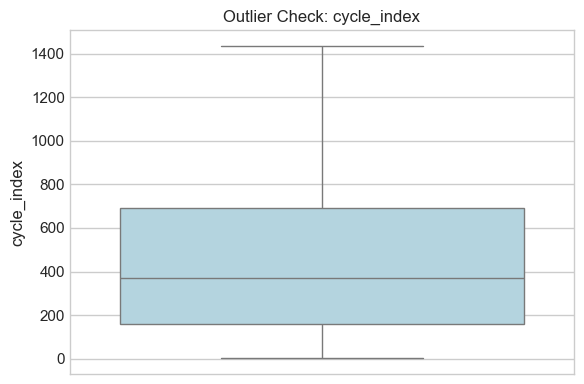

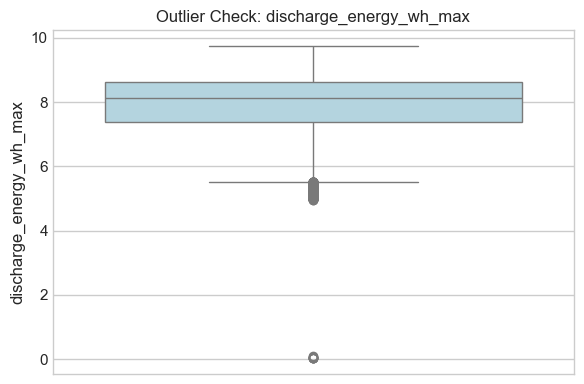

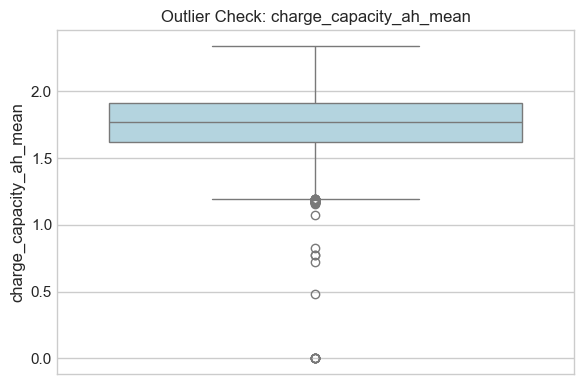

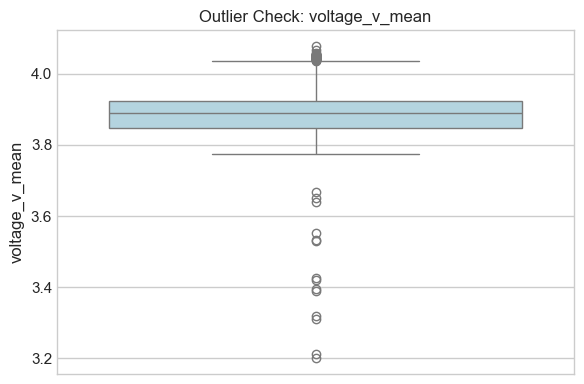

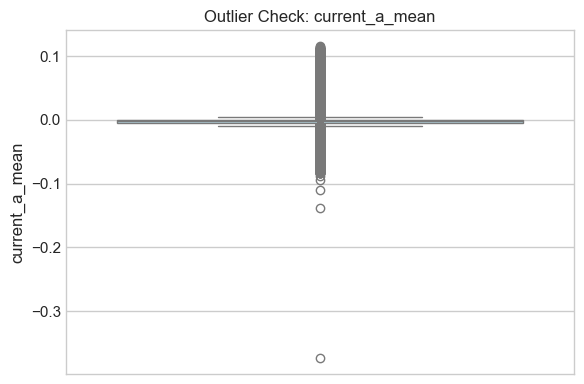

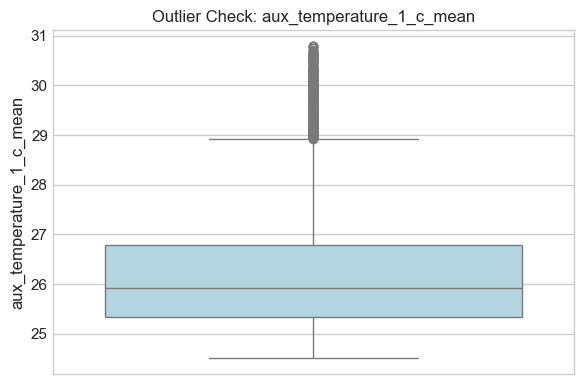

In [44]:
print("=== OUTLIER DETECTION (Z-score > 3) ===")

z_scores = np.abs(zscore(df_final[num_cols].dropna()))
outlier_ratio = (z_scores > 3).mean(axis=0)
outlier_ratio = pd.Series(outlier_ratio, index=df_final[num_cols].dropna().columns)
print(outlier_ratio.sort_values(ascending=False).head(15))

# IQR-based boxplot for selected key features
key_feats = [
    "cycle_index", "discharge_energy_wh_max", "charge_capacity_ah_mean",
    "voltage_v_mean", "current_a_mean", "aux_temperature_1_c_mean"
]

for feat in [f for f in key_feats if f in df_final.columns]:
    plt.figure(figsize=(6, 4))
    if "dataset" in df_final.columns:
        sns.boxplot(data=df_final, x="dataset", y=feat, palette="pastel")
    else:
        sns.boxplot(data=df_final, y=feat, color="lightblue")
    plt.title(f"Outlier Check: {feat}")
    plt.tight_layout()
    plt.show()

=== PAIRPLOT (sample of key features) ===


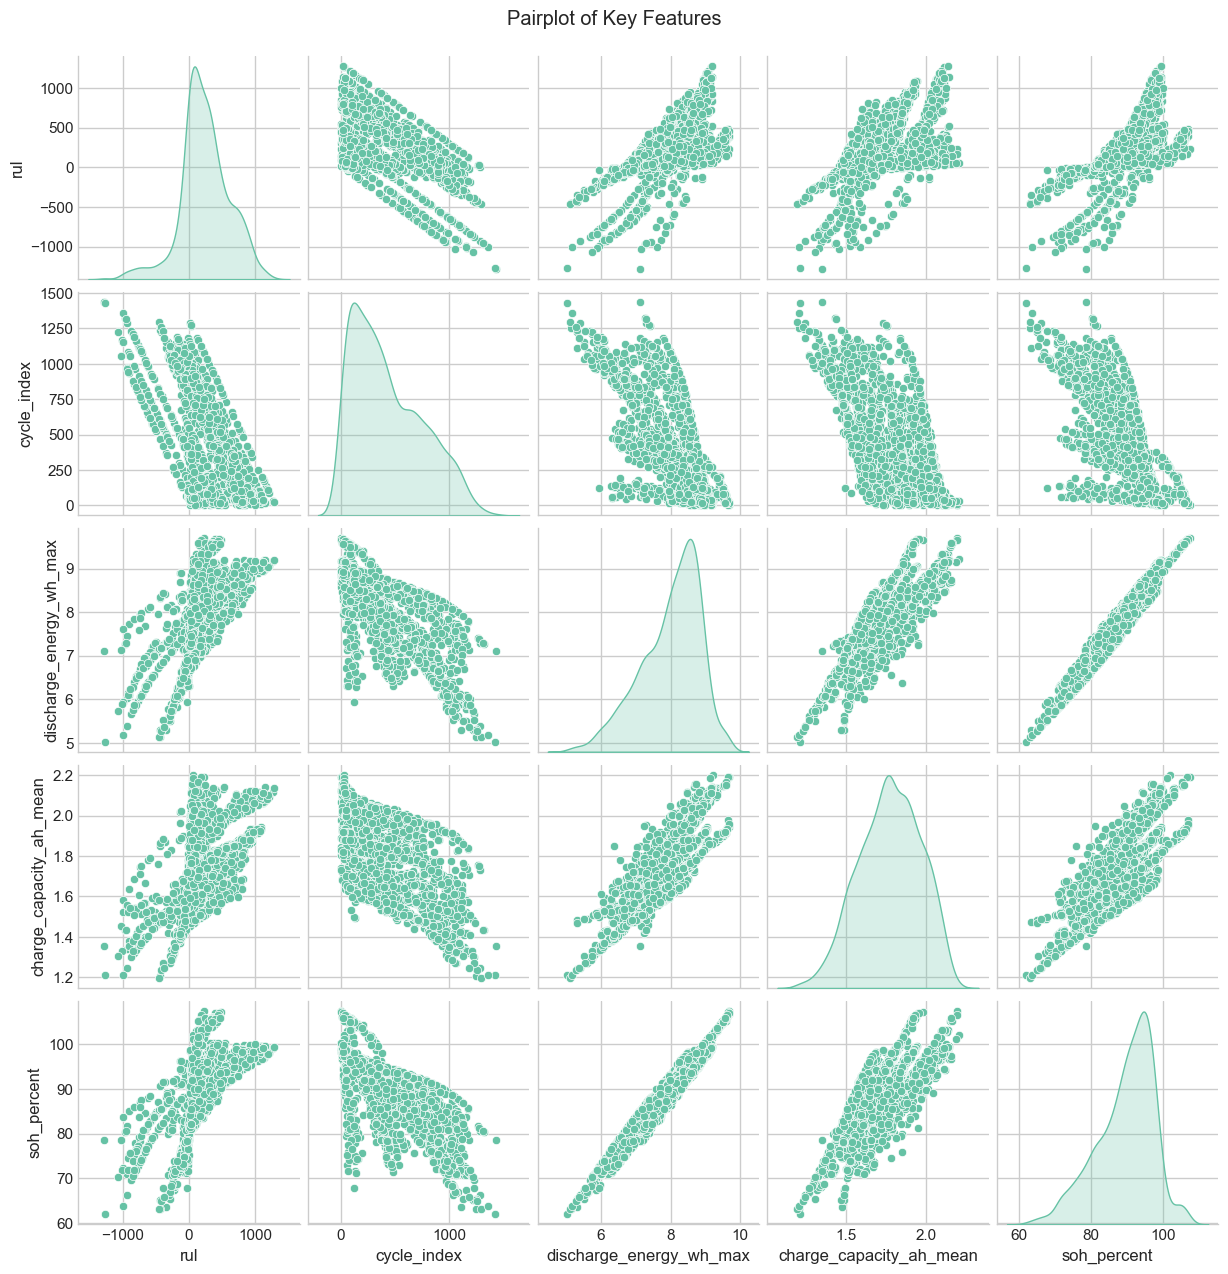

In [41]:
print("=== PAIRPLOT (sample of key features) ===")

pair_feats = [
    TARGET_COL,
    "cycle_index",
    "discharge_energy_wh_max",
    "charge_capacity_ah_mean",
    "soh_percent" if "soh_percent" in df_final.columns else None,]
pair_feats = [f for f in pair_feats if f is not None and f in df_final.columns]

if len(pair_feats) >= 2:
    sample_pp = df_final[pair_feats].dropna()
    if len(sample_pp) > 2000:
        sample_pp = sample_pp.sample(2000, random_state=42)
    sns.pairplot(sample_pp, diag_kind="kde")
    plt.suptitle("Pairplot of Key Features", y=1.02)
    plt.show()

In [40]:
print("=== SCALE / RANGE CHECK ===")

scale_df = df_final[num_cols].agg(["min", "max"]).T
scale_df["range"] = scale_df["max"] - scale_df["min"]
print(scale_df.sort_values("range", ascending=False).head(15))

=== SCALE / RANGE CHECK ===
                                               min          max        range
rul                                   -1281.000000  1299.000000  2580.000000
cycle_index                               1.000000  1436.000000  1435.000000
soh_percent                               0.298394   107.622024   107.323630
battery_id                                1.000000    86.000000    85.000000
rolling_std_soh_percent                   0.000000    51.937290    51.937290
rolling_mean_soh_percent                 57.129989   105.990058    48.860070
aux_temperature_1_c_max                  24.573080    58.917418    34.344338
protocol_id                               1.000000    16.000000    15.000000
charge_energy_wh_max                      0.000000    10.681570    10.681570
discharge_energy_wh_max                   0.023238     9.741455     9.718217
aux_temperature_1_c_std                   0.013244     8.315433     8.302189
aux_temperature_1_c_min                  18.6832

=== PCA EXPLAINED VARIANCE ===


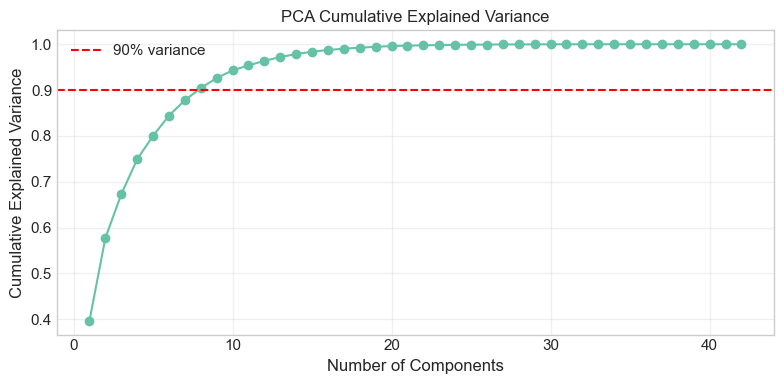

In [39]:
print("=== PCA EXPLAINED VARIANCE ===")

X_pca = df_final[num_cols].dropna()
if len(X_pca) > 10000:
    X_pca = X_pca.sample(10000, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA()
pca.fit(X_scaled)

cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.axhline(0.9, color="red", linestyle="--", label="90% variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== Univariate Distributions ===


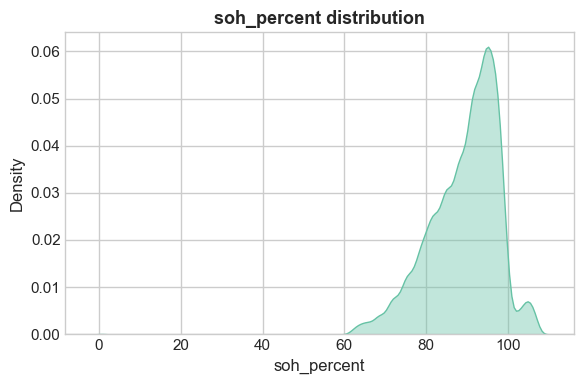

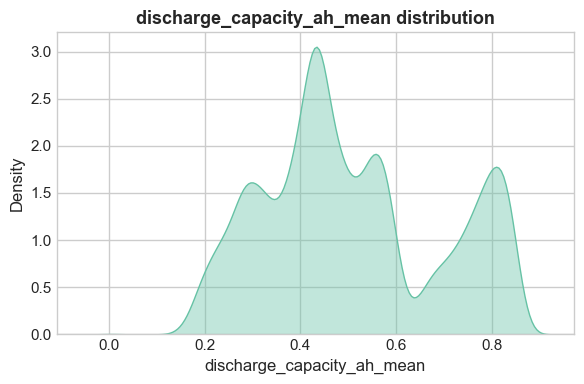

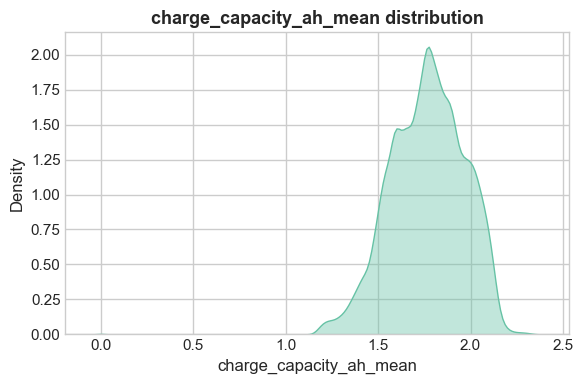

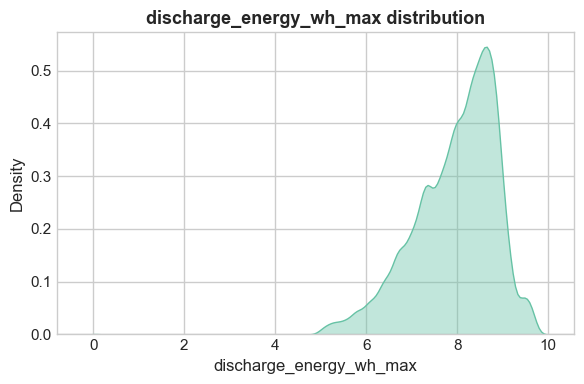

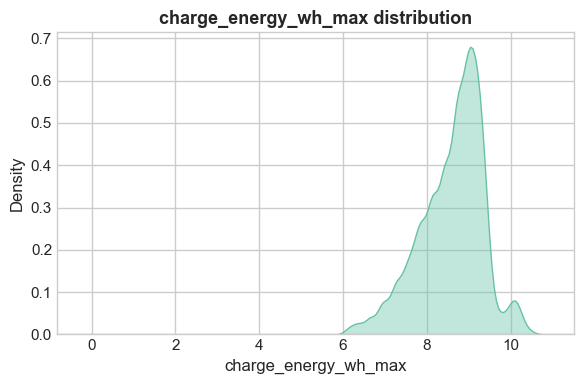

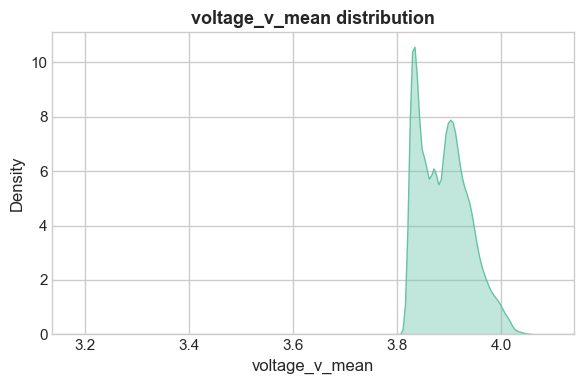

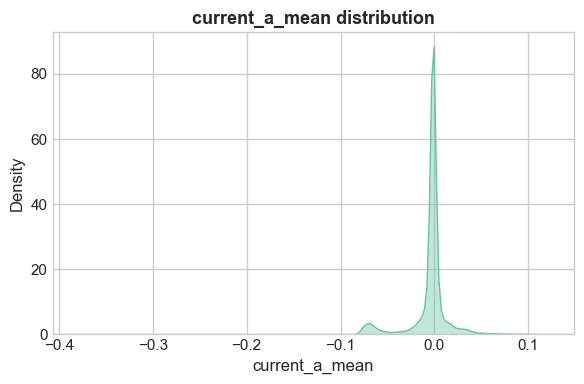

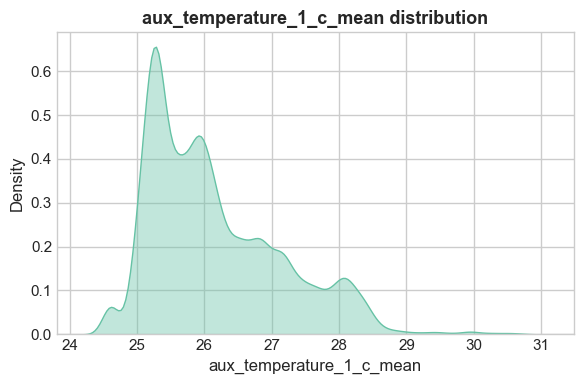

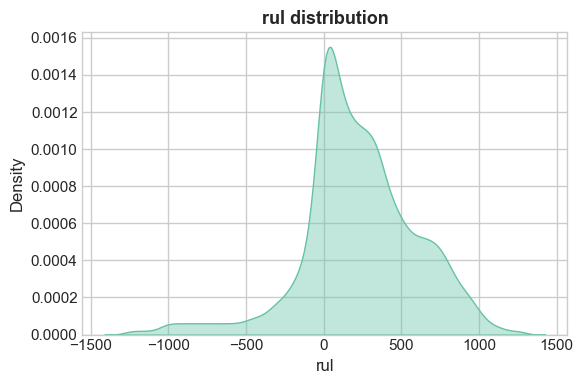

In [37]:
print("=== Univariate Distributions ===")
key_numeric = [
    "soh_percent",
    "discharge_capacity_ah_mean",
    "charge_capacity_ah_mean",
    "discharge_energy_wh_max",
    "charge_energy_wh_max",
    "voltage_v_mean",
    "current_a_mean",
    "aux_temperature_1_c_mean",
    "rul"
]

for col in key_numeric:
    if col not in df_final.columns:
        continue
    
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df_final, x=col, fill=True, alpha=0.4)
    plt.title(f"{col} distribution", fontsize=13, weight="bold")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


=== SOH / RUL vs Cycle Index ===


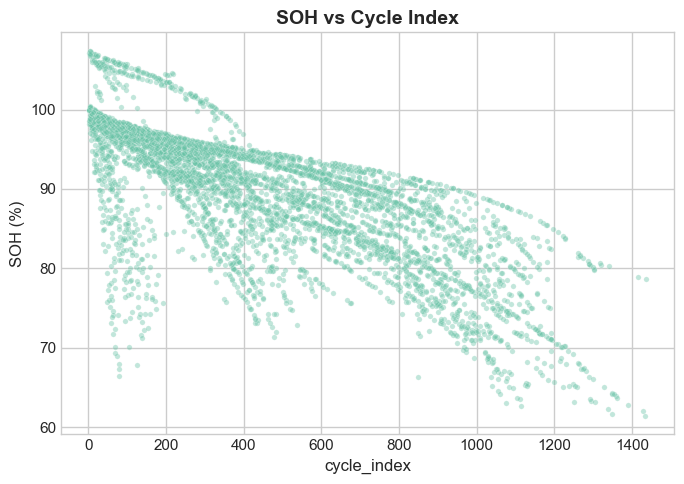

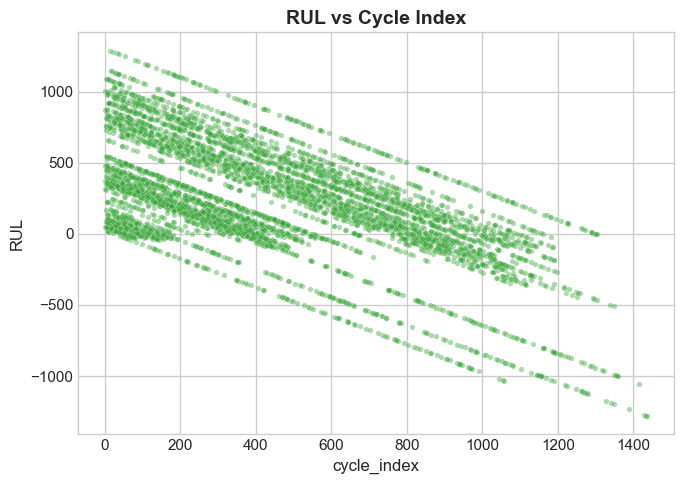

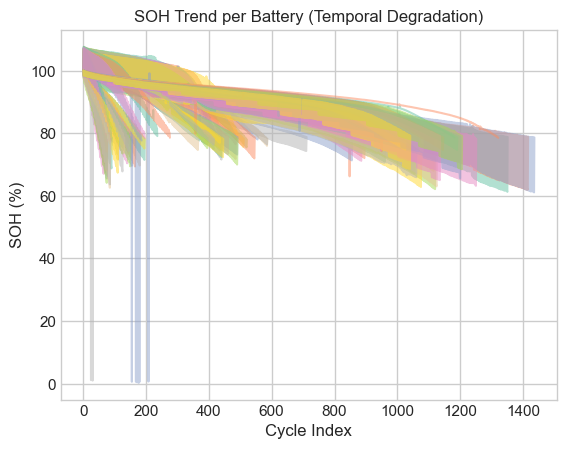

In [57]:
print("=== SOH / RUL vs Cycle Index ===")
if "cycle_index" in df_final.columns:
    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=df_final.sample(min(5000, len(df_final)), random_state=42),
        x="cycle_index",
        y="soh_percent",
        alpha=0.4,
        s=15
    )
    plt.title("SOH vs Cycle Index", fontsize=14, weight="bold")
    plt.xlabel("cycle_index")
    plt.ylabel("SOH (%)")
    plt.tight_layout()
    plt.show()

    if "rul" in df_final.columns:
        plt.figure(figsize=(7,5))
        sns.scatterplot(
            data=df_final.sample(min(5000, len(df_final)), random_state=42),
            x="cycle_index",
            y="rul",
            alpha=0.4,
            s=15,
            color="tab:green"
        )
        plt.title("RUL vs Cycle Index", fontsize=14, weight="bold")
        plt.xlabel("cycle_index")
        plt.ylabel("RUL")
        plt.tight_layout()
        plt.show()

for bid, sub in df_final.groupby("battery_id"):
    plt.plot(sub["cycle_index"], sub["soh_percent"],alpha=0.5)
plt.title("SOH Trend per Battery (Temporal Degradation)")
plt.xlabel("Cycle Index")
plt.ylabel("SOH (%)")
plt.show()

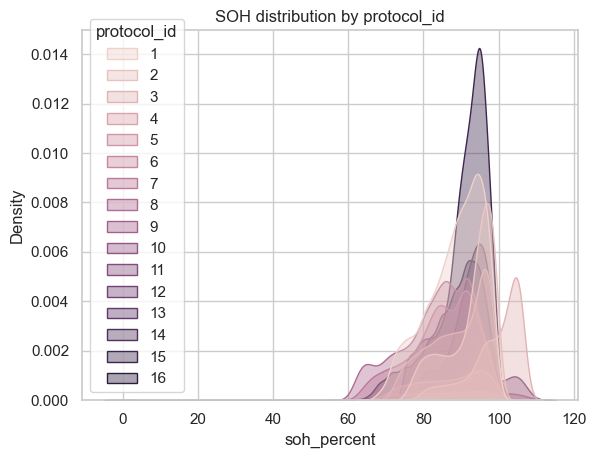

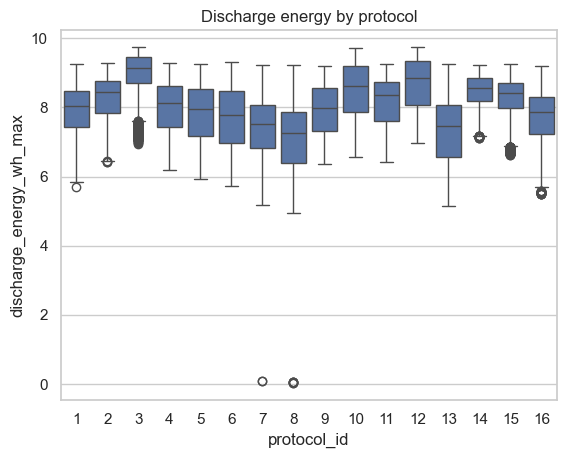

In [32]:
sns.kdeplot(data=df_final, x="soh_percent", hue="protocol_id", fill=True, alpha=0.4)
plt.title("SOH distribution by protocol_id")
plt.show()

sns.boxplot(data=df_final, x="protocol_id", y="discharge_energy_wh_max")
plt.title("Discharge energy by protocol")
plt.show()

Clustered heatmap (hierarchical correlation)


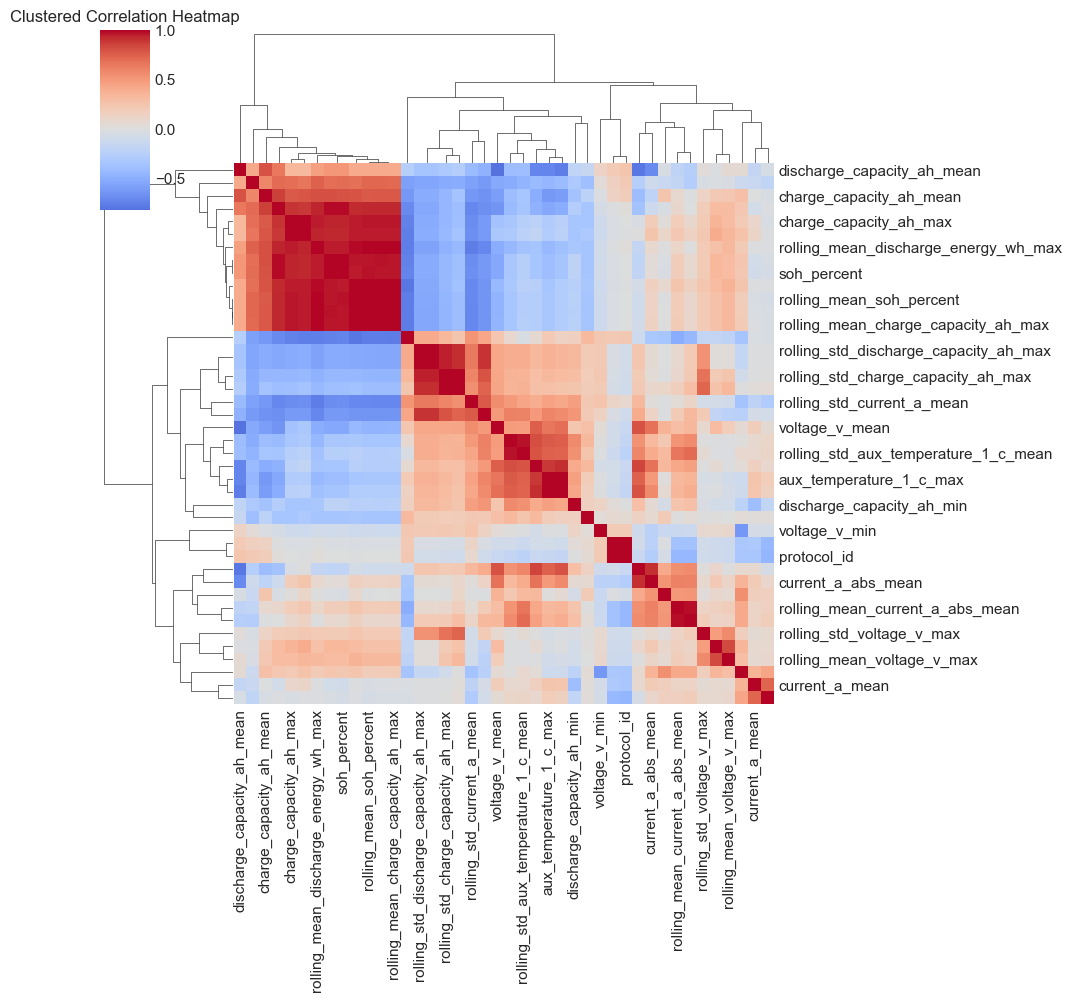

In [51]:
print('Clustered heatmap (hierarchical correlation)')
sns.clustermap(df_final.corr(), cmap="coolwarm", center=0)
plt.title("Clustered Correlation Heatmap")
plt.show()


Feature-to-Target Nonlinear Check


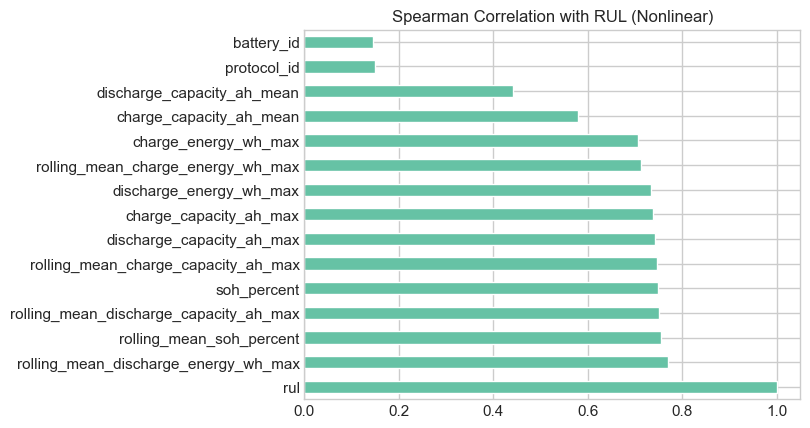

In [53]:
print('Feature-to-Target Nonlinear Check')
spearman_corr = df_final.corr(method='spearman')['rul'].sort_values(ascending=False)
spearman_corr.head(15).plot(kind='barh')
plt.title("Spearman Correlation with RUL (Nonlinear)")
plt.show()

Feature Interactions


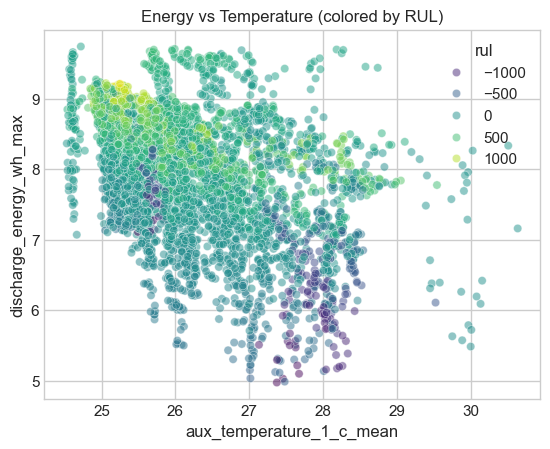

In [58]:
print('Feature Interactions')
sns.scatterplot(
    data=df_final.sample(5000, random_state=42),
    x="aux_temperature_1_c_mean",
    y="discharge_energy_wh_max",
    hue="rul",
    palette="viridis",
    alpha=0.5
)
plt.title("Energy vs Temperature (colored by RUL)")
plt.show()